    # Evolution de la politique d'augmentation de données

Cette fois nous ferons plus attention à ne pas introduire des images du dataset de test dans le dataset d'entraînement, même si elles sont modifiées.

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

import albumentations as alb

import tensorflow as tf
from tensorflow.keras import layers

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
2024-07-09 11:00:28.461111: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 11:00:28.467305: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 11:00:28.510375: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 11:00:28.561037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 11:00:28.608228: E external/local_xla/xl

#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "../chest_Xray/"
images_files = os.listdir(common_path)
subfolders = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]


# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback=None, limit_size=None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path, file_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)


def display_imgs(imgs, titles=[], plot_size=(1, 1), figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

### Préparation des datasets

In [3]:
original_datasetX = []
original_datasetY = []
augmented_normal_datasetX = []
augmented_normal_datasetY = []
augmented_pneumonia_datasetX = []
augmented_pneumonia_datasetY = []

test_datasetX = []
test_datasetY = []

image_size = (200, 200)


def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    original_datasetX.append(new_img)
    # replace normal with 0 and pneumonia with 1 in order to have numerical labels
    category = 0 if category == "NORMAL" else 1
    original_datasetY.append(category)

browse_imgs(load_datasets)

# après avoir chargé le dataset, on met directement de coté les images de test afin d'être sûr de ne pas les modifier
original_datasetX, test_datasetX, original_datasetY, test_datasetY = train_test_split(original_datasetX, original_datasetY, test_size=0.2, random_state=1)

for i in range(0, len(original_datasetX)):
    image = original_datasetX[i]
    category = original_datasetY[i]
    transformed_img = alb.hflip(image)
    
    if category == 0:
        augmented_normal_datasetX.append(transformed_img)
        augmented_normal_datasetY.append(category)

    else:
        augmented_pneumonia_datasetX.append(transformed_img)
        augmented_pneumonia_datasetY.append(category)

# normalizing the images
original_datasetX = np.array(original_datasetX) / 255
original_datasetY = np.array(original_datasetY)
test_datasetX = np.array(test_datasetX) / 255
test_datasetY = np.array(test_datasetY)
augmented_normal_datasetX = np.array(augmented_normal_datasetX) / 255
augmented_normal_datasetY = np.array(augmented_normal_datasetY)
augmented_pneumonia_datasetX = np.array(augmented_pneumonia_datasetX) / 255
augmented_pneumonia_datasetY = np.array(augmented_pneumonia_datasetY)

# la seed nous permettra de mélanger les datasets X et Y de la même manière
random_seed = 5

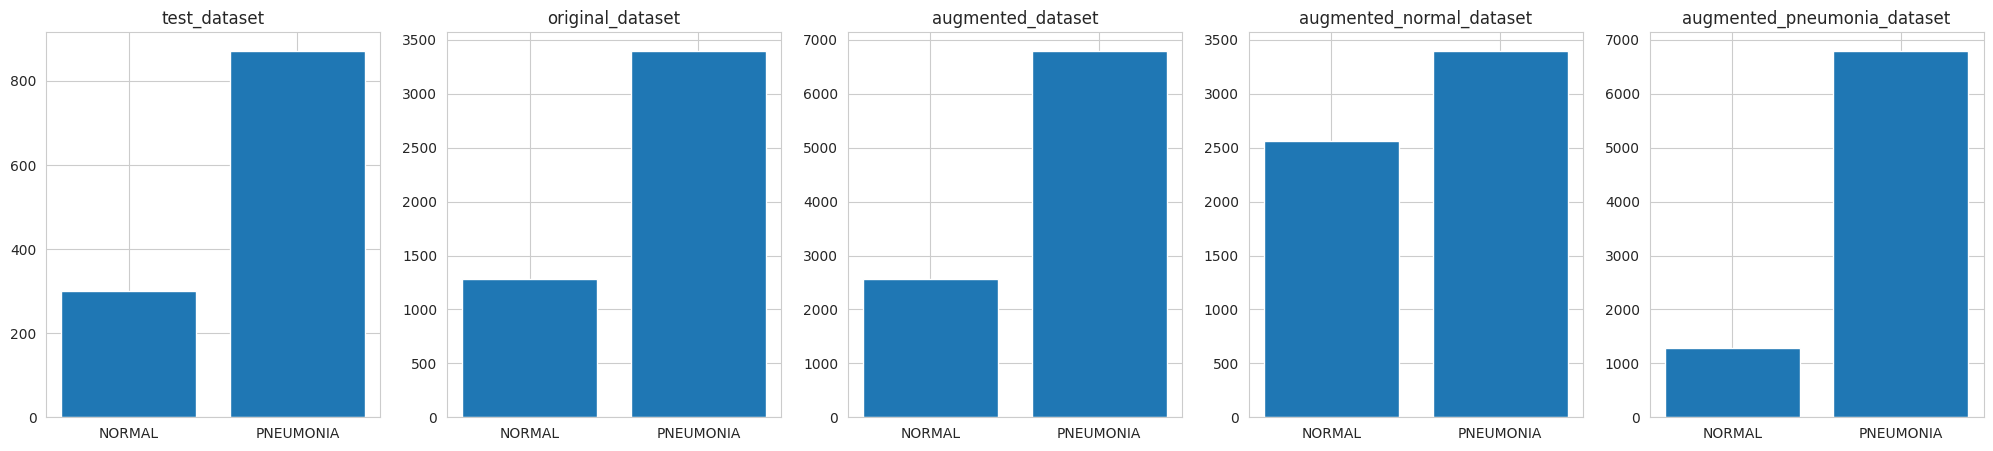

In [4]:
def display_distribution(datasetsY, datasets_names):
    fig, ax = plt.subplots(1, len(datasetsY), figsize=(5 * len(datasetsY), 5))
    #iterate on each datasetY to count the number of each category
    for index, datasetY in enumerate(datasetsY):
        dataset = datasetY.tolist()
        ax[index].bar(["NORMAL", "PNEUMONIA"], [dataset.count(0), dataset.count(1)])
        ax[index].set_title(datasets_names[index])
        
    plt.show()


display_distribution([test_datasetY,
                      original_datasetY,
                      np.concatenate((augmented_normal_datasetY,np.concatenate((original_datasetY, augmented_pneumonia_datasetY)))),
                      np.concatenate((original_datasetY, augmented_normal_datasetY)),
                      np.concatenate((original_datasetY, augmented_pneumonia_datasetY))],
                     ["test_dataset", "original_dataset", "augmented_dataset", "augmented_normal_dataset", "augmented_pneumonia_dataset"])

### On doit faire attention à bien tester uniquement avec des données originales pour être sûr de nos résultats

#### CNN - Convolution Neural Network

In [5]:
# This line sets the number of output classes for your model
num_classes = 1
# This line sets the size of the kernel to be used in the convolutional layers. The kernel is
# a small matrix that is used for blurring, sharpening, embossing, edge detection, and more
core_size = 4

# he Sequential model is a linear stack of layers that you can add to in order
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(16, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 197, 197, 16)   │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 95, 95, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     3,097,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,219,829 (12.28 MB)

 Trainable params: 3,219,829 (12.28 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['recall'])

In [7]:
def train_and_test_with_confusion_matrix(datasetX, datasetY):
    xtrain, xval, ytrain, yval = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(xtrain,
          ytrain,
          validation_data=(xval, yval),
          epochs=2)
    
    y_pred = model.predict(test_datasetX)
    # Convert probabilities to class labels
    y_pred_label = np.round(y_pred).astype(int)
    
    cm = confusion_matrix(test_datasetY, y_pred_label)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
    plt.show()
    
    recall = recall_score(test_datasetY, y_pred_label)
    precision = precision_score(test_datasetY, y_pred_label)
    f1score = f1_score(test_datasetY, y_pred_label)
    print("recall : ", recall)
    print("precision : ", precision)
    print("f1score : ", f1score)

### testing model on original dataset

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - loss: 0.4935 - recall: 0.9291 - val_loss: 0.1878 - val_recall: 0.9583
Epoch 2/2
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - loss: 0.2152 - recall: 0.9637 - val_loss: 0.1546 - val_recall: 0.9628
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


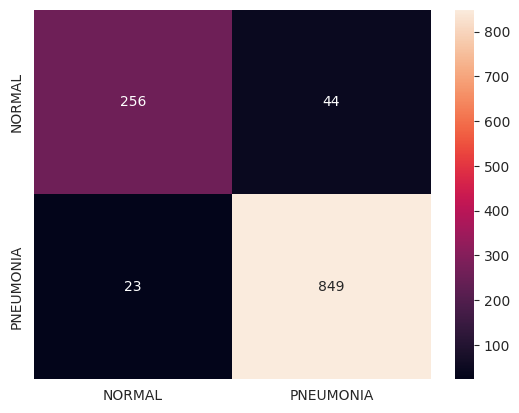

recall :  0.9736238532110092
precision :  0.9507278835386338
f1score :  0.9620396600566572


In [8]:
train_and_test_with_confusion_matrix(original_datasetX, original_datasetY)

### testing model on augmented dataset

Epoch 1/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - loss: 0.1721 - recall: 0.9636 - val_loss: 0.1293 - val_recall: 0.9920
Epoch 2/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - loss: 0.1291 - recall: 0.9742 - val_loss: 0.1079 - val_recall: 0.9753
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


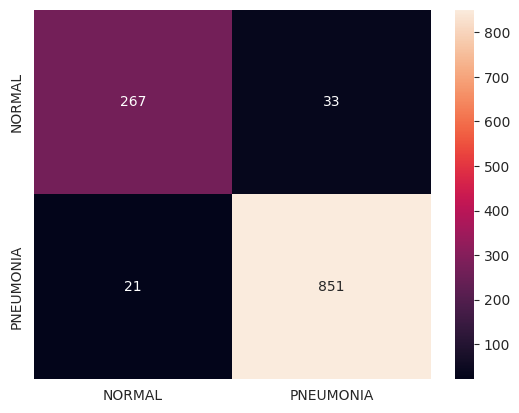

recall :  0.9759174311926605
precision :  0.9626696832579186
f1score :  0.969248291571754


In [9]:
x = np.concatenate((augmented_normal_datasetX,np.concatenate((original_datasetX, augmented_pneumonia_datasetX))))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((augmented_normal_datasetY,np.concatenate((original_datasetY, augmented_pneumonia_datasetY))))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)

### testing model on augmented normal dataset (only normal images are augmented in order to balance the dataset)

Epoch 1/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 0.1138 - recall: 0.9666 - val_loss: 0.2797 - val_recall: 0.8018
Epoch 2/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - loss: 0.1074 - recall: 0.9666 - val_loss: 0.0804 - val_recall: 0.9747
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


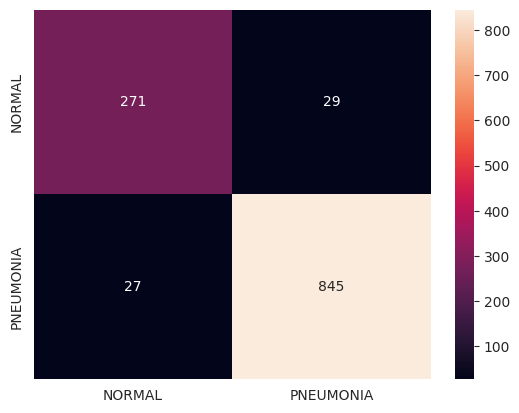

recall :  0.9690366972477065
precision :  0.9668192219679634
f1score :  0.9679266895761741


In [10]:
x = np.concatenate((original_datasetX, augmented_normal_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_normal_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)

### testing model on augmented pneumonia dataset (only pneumonia images are augmented in order to focus on pneumonia detection)

Epoch 1/2
203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - loss: 0.1218 - recall: 0.9738 - val_loss: 0.0502 - val_recall: 0.9892
Epoch 2/2
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - loss: 0.0418 - recall: 0.9918 - val_loss: 0.0524 - val_recall: 0.9971
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


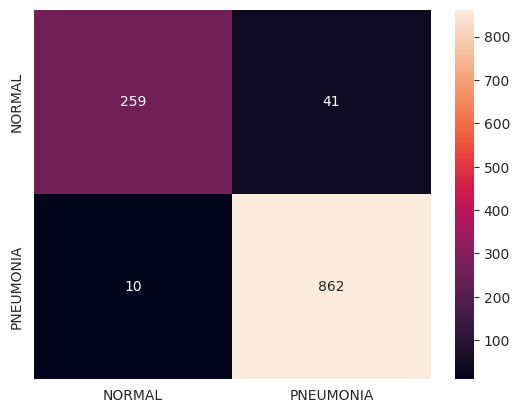

recall :  0.9885321100917431
precision :  0.9545957918050941
f1score :  0.9712676056338028


In [11]:
x = np.concatenate((original_datasetX, augmented_pneumonia_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_pneumonia_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)